In [1]:
from IPython.display import HTML, Markdown, display
from dataset import QuickDrawDataset, TUBerlinDataset, SketchyDataset
from prepare_data import convert_and_quantize_svg, stroke_to_rdp, clean_svg
from utils import (
    AbsolutePenPositionTokenizer,
    DeltaPenPositionTokenizer,
    tensor_to_svg,
    svg_to_tensor_quantized,
    tensor_to_svg,
)
import re


def simplify(original_svg):
    simplified = stroke_to_rdp(original_svg, 3.0)
    simplified = clean_svg(simplified, stroke_width=0.8)
    return simplified

# QuickDrawDataset

svg -> quantized tensor -> svg

In [2]:
dataset = QuickDrawDataset(label_names=["bulldozer"], download=True)
outputs = ""

for svg_content in dataset[0:3]:
    output = convert_and_quantize_svg(svg_content, bins=128)
    outputs += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Original, length: {len(svg_content)}</b><br>{svg_content}</div>'
    outputs += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Quantized, length: {len(output)}</b><br>{output}</div>'
display(HTML(outputs))

# Note: quantization is faster when converting directly from svg to quantized tensor
quantization_levels = [16, 32, 64, 128, 256]
svgs_inline = ""
for bins in quantization_levels:
    quantized_tensor = svg_to_tensor_quantized(dataset[0], bins=bins)
    reconstructed_svg = tensor_to_svg(quantized_tensor, size=bins)
    svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Recon: {bins} bins</b><br>{reconstructed_svg}</div>'
display(HTML(svgs_inline))

Loading QuickDrawDataset: 1it [00:00, 308.06it/s]


## Tokenizer representations

svg -> encoder / decoder -> svg

In [3]:
dataset = QuickDrawDataset(["cat"], download=True)
original_svg = dataset[0]
# original_svg = simplify(original_svg)

# Using a point based representation there a half as many points needed to be represented
pos_tokenizer = AbsolutePenPositionTokenizer(bins=64)
encoded = pos_tokenizer.encode(original_svg)
print(
    f"Vocab size: {len(pos_tokenizer.vocab)} \n Encoded length: {len(encoded)} \n Encoded tokens: {encoded}"
)

decoded_svg = pos_tokenizer.decode(encoded)
svgs_inline = f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Original</b><br>{original_svg}</div>'
svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Reconstructed</b><br>{decoded_svg}</div>'

display(Markdown(f"### {pos_tokenizer.__class__.__name__}"))
display(HTML(svgs_inline))

# Using delta positions (dx, dy) is good because it is relative but it leads to a larger tokenizer vocab size
delta_tokenizer = DeltaPenPositionTokenizer(bins=64)
encoded = delta_tokenizer.encode(original_svg)
print(
    f"Vocab size: {len(delta_tokenizer.vocab)} \n Encoded length: {len(encoded)} \n Encoded tokens: {encoded}"
)

decoded_svg = delta_tokenizer.decode(encoded)
svgs_inline = f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Original</b><br>{original_svg}</div>'
svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Reconstructed</b><br>{decoded_svg}</div>'

display(Markdown(f"### {delta_tokenizer.__class__.__name__}"))
display(HTML(svgs_inline))

Loading QuickDrawDataset: 1it [00:00, 532.95it/s]

Vocab size: 4100 
 Encoded length: 64 
 Encoded tokens: [4098, 4096, 2066, 1802, 1543, 1747, 1236, 1046, 921, 798, 801, 869, 1001, 1389, 2159, 2478, 2732, 3237, 3424, 3420, 3417, 3286, 2963, 2752, 2568, 2512, 2065, 4096, 1249, 480, 160, 4096, 1255, 424, 43, 4096, 1387, 879, 626, 4096, 2785, 3488, 3937, 4002, 4096, 2788, 4073, 4096, 2728, 3313, 3444, 4096, 2080, 1761, 1762, 1763, 2084, 2211, 2209, 1888, 4096, 1688, 1692, 4099]


### AbsolutePenPositionTokenizer

Vocab size: 16645 
 Encoded length: 64 
 Encoded tokens: [16643, 16641, 12466, 7796, 7801, 8719, 7289, 7935, 8065, 8067, 8323, 8453, 8582, 9098, 9870, 8964, 8834, 9345, 8702, 8316, 8317, 8059, 7672, 7914, 7941, 8199, 7418, 16641, 6659, 6771, 7675, 16641, 10520, 6644, 7549, 16641, 11029, 7292, 7807, 16641, 12689, 9738, 9224, 8450, 16641, 5871, 10905, 16641, 5610, 9490, 8581, 16641, 5591, 7676, 8321, 8321, 8966, 8577, 8318, 7674, 16641, 7925, 8324, 16644]


### DeltaPenPositionTokenizer

# TUBerlinDataset

In [4]:
dataset = TUBerlinDataset(label_names=["backpack"], download=True)
outputs = ""

for svg_content in dataset[0:3]:
    output = convert_and_quantize_svg(svg_content, bins=256)
    outputs += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Original, length: {len(svg_content)}</b><br>{svg_content}</div>'
    outputs += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Quantized, length: {len(output)}</b><br>{output}</div>'

display(HTML(outputs))

Loading TUBerlinDataset: 1it [00:00, 9098.27it/s]


# SketchyDataset 

In [5]:
from IPython.display import HTML
from dataset import SketchyDataset
from prepare_data import (
    stroke_to_bezier,
    convert_and_quantize_svg,
    count_curves,
    stroke_to_rdp,
)

sketchy_dataset = SketchyDataset(["cat"], download=True)
svg_content_original = sketchy_dataset[1]

# Example of different subsampling levels, notice the nose and other features are lost at lower levels
svgs_inline = ""

for level in [2, 5, 10, 20]:
    svg_content = stroke_to_bezier(svg_content_original, level)
    svg_content = convert_and_quantize_svg(svg_content, 256)
    svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Subsampling (level {level}), num curves: {count_curves(svg_content)}, char len: {len(svg_content)}</b><br>{svg_content}</div>'
display(HTML(svgs_inline))


# Different maxError values for subsampling.
svgs_inline = ""

for maxError in [50.0, 20.0, 10.0, 1.0]:
    svg_content = stroke_to_bezier(svg_content_original, 20, maxError=maxError)
    svg_content = convert_and_quantize_svg(svg_content, 256)
    svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>Subsampling (maxError {maxError}), num curves: {count_curves(svg_content)}, char len: {len(svg_content)}</b><br>{svg_content}</div>'
display(HTML(svgs_inline))

rdp = stroke_to_rdp(svg_content_original, epsilon=3.0)
svg_content = stroke_to_bezier(rdp, num_samples=40, maxError=20.0)  # tuning
svg_content = convert_and_quantize_svg(svg_content, 64)

display(
    HTML(
        f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>RDP + Subsampling num curves: {count_curves(svg_content)}, char len: {len(svg_content)}</b><br>{svg_content}</div>'
    )
)

Loading SketchyDataset: 1it [00:00, 7206.71it/s]


In [6]:
from IPython.display import HTML
from prepare_data import (
    stroke_to_bezier_single,
    count_curves,
    convert_and_quantize_svg,
)

original_svg = """<svg viewBox="0 0 256 256"><g stroke-width="0.8">
<path d="M 26 22 L 32 50 L 33 84" stroke="black" fill="none"/>
<path d="M 24 24 L 56 16 L 114 7 L 113 75 L 111 82 L 105 86" stroke="black" fill="none"/>
<path d="M 8 101 L 26 96 L 130 84" stroke="black" fill="none"/>
<path d="M 7 103 L 6 153 L 11 156 L 24 157 L 59 150 L 127 147" stroke="black" fill="none"/>
<path d="M 138 86 L 132 142 L 134 148" stroke="black" fill="none"/>
<path d="M 133 85 L 133 78 L 157 18 L 173 0 L 189 24 L 203 57 L 207 91 L 196 106 L 195 126 L 203 134 L 214 138 L 229 139 L 237 136 L 247 128 L 240 105 L 226 89 L 209 87 L 204 92" stroke="black" fill="none"/>
<path d="M 202 140 L 209 147 L 211 146 L 215 127 L 221 141 L 225 140 L 232 130 L 238 137 L 247 124 L 255 121" stroke="black" fill="none"/>
<path d="M 201 141 L 201 141" stroke="black" fill="none"/>
<path d="M 200 128 L 204 137" stroke="black" fill="none"/>
<path d="M 2 163 L 38 150 L 155 137 L 163 139 L 166 149 L 166 156 L 158 166 L 148 173 L 121 180 L 41 191 L 23 191 L 7 185 L 1 176 L 1 160 L 14 152" stroke="black" fill="none"/>
</g></svg>"""

# Note: quantization is faster when converting directly from svg to quantized tensor
print("svg -> subsampled -> quantized tensor -> svg")
print("Original number of curves:", count_curves(original_svg))

subsampled = stroke_to_bezier_single(
    original_svg, num_samples=40, maxError=20.0
)  # tuning
print("Subsampled number of curves:", count_curves(subsampled))

quantization_levels = [16, 32, 64, 128, 256]
svgs_inline = ""
svgs_inline_comparison = ""

for bins in quantization_levels:
    quantized_tensor = convert_and_quantize_svg(subsampled, bins=bins)
    svgs_inline += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>char len: {len(quantized_tensor)}</b><br>{quantized_tensor}</div>'

    print(f"Quantized tensor (bins={bins}): {quantized_tensor}")

    comparison_svg = convert_and_quantize_svg(original_svg, bins=bins)
    svgs_inline_comparison += f'<div style="display:inline-block; width: 150px; background-color: white; margin-right:10px;"><b>char len: {len(comparison_svg)}</b><br>{comparison_svg}</div>'

# This example shows how we may be able to use fewer curves to represent the same shape geometry as using just lines
print()
print("Greedy Bezier fitting -> quantized tensor -> svg")
display(HTML(svgs_inline))

print("quantized tensor -> svg")
display(HTML(svgs_inline_comparison))

svg -> subsampled -> quantized tensor -> svg
Original number of curves: 58
Subsampled number of curves: 21
Quantized tensor (bins=16): <svg viewBox="-1.5075 -1.1229700538379253 18.015 13.400640646055102" xmlns="http://www.w3.org/2000/svg"><g stroke-width="0.3"><path d="M2,1C2,3 2,4 2,5M1,1C3,1 5,0 7,0C7,0 7,3 7,3C7,4 7,5 6,5M0,6C3,5 5,5 8,5M0,6C0,7 0,8 0,9C0,9 6,9 7,9M8,5C8,6 8,8 8,9M8,5C8,4 9,0 10,0C10,0 12,3 12,3C12,5 11,6 11,7C12,8 13,8 13,8C15,8 14,4 12,5M12,8C13,9 13,7 13,7C13,8 13,8 13,8C13,8 14,7 15,7M12,8C12,8 12,8 12,8M0,10C1,9 9,7 10,9C10,9 9,10 9,10C8,11 1,12 0,10C0,10 0,9 1,9" fill="none" stroke="#000000" /></g></svg>
Quantized tensor (bins=32): <svg viewBox="-3.1155 -2.3176534977309426 37.231 27.656841972771314" xmlns="http://www.w3.org/2000/svg"><g stroke-width="0.3"><path d="M3,3C4,5 4,8 4,10M3,3C6,2 10,0 14,1C14,1 14,6 14,7C14,8 14,10 13,10M1,12C6,11 11,11 16,10M1,12C1,14 0,17 1,18C1,19 13,18 15,18M17,10C16,13 16,16 16,18M16,10C16,9 19,1 21,0C22,0 24,6 24,7C26,11 23,13 

quantized tensor -> svg


In [7]:
# Sketches should have labels other than class label representing semantic accuracy (good, incomplete, poor)
# for example a cat missing eyes or whiskers may still be recognizable as a cat, however if it is missing key features and is misshapen it may be unrecognizable
# We want to model to learn to generate semantically accurate sketches, not just syntactically correct ones
# Simplifying paths seems like an important step to improve semantic accuracy, because it could help to remove unneeded details and noise that may confuse the model.

In [8]:
from utils import AbsoluteBezierPenPositionTokenizer
from dataset import SketchyDataset
from IPython.display import display, HTML
from prepare_data import stroke_to_bezier, convert_and_quantize_svg

tokenizer = AbsoluteBezierPenPositionTokenizer(bins=32)
sketchy_dataset = SketchyDataset(["dog"], download=True)

decoded_svg_inline = ""

for i in range(20):
    svg_content = sketchy_dataset[i]
    worker_score = re.search(r"Worker Score: ([\d.]+)", svg_content)
    worker_score = float(worker_score.group(1)) or 0.0

    # svg_content = stroke_to_rdp(svg_content, epsilon=3.0)
    svg_content = stroke_to_bezier(
        svg_content, num_samples=100, maxError=10.0
    )  # tuning
    q = convert_and_quantize_svg(svg_content, bins=256)

    encoded = tokenizer.encode(q)
    decoded = tokenizer.decode(encoded, stroke_width=0.3)

    decoded_svg_inline += f'<div style="display:inline-block; width: 150px; background-color: white; padding: 10px;"><b>Worker Score: {worker_score}, Encoded Length: {len(encoded)}</b><br>{decoded}</div>'

display(HTML(decoded_svg_inline))

Loading SketchyDataset: 1it [00:00, 9664.29it/s]


In [9]:
from utils import AbsoluteBezierPenPositionTokenizer
from dataset import TUBerlinDataset
from IPython.display import display, HTML
from prepare_data import stroke_to_bezier, convert_and_quantize_svg

tokenizer = AbsoluteBezierPenPositionTokenizer(bins=32)
labels = ["dog"]
tub_dataset = TUBerlinDataset(labels, download=True)

decoded_svg_inline = ""

for i in range(20):
    svg_content = tub_dataset[i]

    # svg_content = stroke_to_rdp(svg_content, epsilon=3.0)
    svg_content = stroke_to_bezier(
        svg_content, num_samples=100, maxError=10.0
    )  # tuning
    q = convert_and_quantize_svg(svg_content, bins=256)

    encoded = tokenizer.encode(q)
    decoded = tokenizer.decode(encoded, stroke_width=0.3)

    decoded_svg_inline += f'<div style="display:inline-block; width: 150px; background-color: white; padding: 10px;"><b>Encoded Length: {len(encoded)}</b><br>{decoded}</div>'

display(HTML(decoded_svg_inline))

Loading TUBerlinDataset: 1it [00:00, 19239.93it/s]


Loading QuickDrawDataset: 1it [00:00, 496.84it/s]


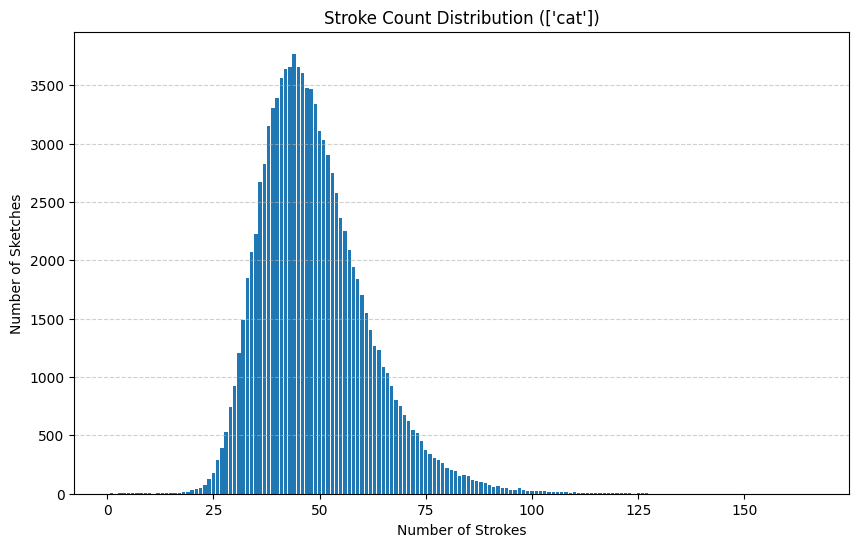

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
from prepare_data import count_curves
from dataset import QuickDrawDataset

labels = ["cat"]
dataset = QuickDrawDataset(labels)

freq = Counter(count_curves(svg) for svg in dataset)
x = sorted(freq)
y = [freq[k] for k in x]

plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.xlabel("Number of Strokes")
plt.ylabel("Number of Sketches")
plt.title(f"Stroke Count Distribution ({labels})")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()